In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
import tensorflow.keras.layers as L
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow.keras import layers
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
batch_size = 6
lr = 1e-3
epochs = 300
width = 256
height = 256

In [3]:
dataset_path = os.path.join("/kaggle/input/uavid-v1")
files_dir = os.path.join("files", "modified_uavid_dataset")
model_file = os.path.join(files_dir, "UnetModel.keras")
log_file = os.path.join(files_dir, "Log-Unet.csv")

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
create_dir(files_dir)

In [4]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "uavid_train","seq1", "Images", "*")))
    train_y = sorted(glob(os.path.join(path, "uavid_train","seq1", "Labels", "*")))

    valid_x = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Images", "*")))
    valid_y = sorted(glob(os.path.join(path, "uavid_val", "seq16", "Labels", "*")))

    return (train_x, train_y), (valid_x, valid_y)

In [5]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

train_x, additional_valid_x, train_y, additional_valid_y = train_test_split(
    train_x, train_y, test_size=100, random_state=42
)

valid_x = np.concatenate([valid_x, additional_valid_x], axis=0)
valid_y = np.concatenate([valid_y, additional_valid_y], axis=0)


print(f"New Train: {len(train_x)} - {len(train_y)}")
print(f"New Valid: {len(valid_x)} - {len(valid_y)}")

New Train: 500 - 500
New Valid: 170 - 170


In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [7]:
# color_map = {
#     (0, 0, 0): 0,         # Background clutter
#     (128, 0, 0): 1,       # Building
#     (128, 64, 128): 2,    # Road
#     (0, 128, 0): 3,       # Tree
#     (128, 128, 0): 4,     # Low vegetation
#     (64, 0, 128): 5,      # Moving car
#     (192, 0, 192): 6,     # Static car
#     (64, 64, 0): 7        # Human
# }

# def read_mask(path):
#     path = path.decode()
#     mask = cv2.imread(path)  
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) 
#     mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

#     class_indices = np.zeros((height, width), dtype=np.uint8)

#     for rgb, idx in color_map.items():
#         class_indices[(mask == rgb).all(axis=-1)] = idx

#     return class_indices.astype(np.uint8) 

In [8]:
color_map = {
    (0, 0, 0): 0,         # Background clutter
    (128, 0, 0): 1,       # Building
    (128, 64, 128): 2,    # Road
    (0, 128, 0): 3,       # Tree
    (128, 128, 0): 4,     # Low vegetation
    (64, 0, 128): 5,      # Moving car
    (192, 0, 192): 6,     # Static car
    (64, 64, 0): 7        # Human
}

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
    class_indices = np.zeros((height, width), dtype=np.uint8)
    for rgb, idx in color_map.items():
        class_indices[(mask == rgb).all(axis=-1)] = idx
    
    # Convert to one-hot encoding
    one_hot_mask = tf.one_hot(class_indices, depth=8)  # 8 classes as per your color_map
    return one_hot_mask.numpy()

In [9]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 8])  # 8 classes
    return x, y

In [10]:
def tf_dataset(x, y, batch=6):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
#test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

In [12]:
# # Create a custom color map based on the color_map dictionary
# color_map_values = list(color_map.keys())
# color_map_rgb = np.array(color_map_values) / 255.0  # Normalize to 0-1 range for matplotlib

# def plot_samples_with_labels(dataset, title):
#     plt.figure(figsize=(12, 12))
#     for i, (images, masks) in enumerate(dataset.take(1)):  # Take a single batch
#         for j in range(4):  # Loop over first four images
#             # Plot the image
#             plt.subplot(4, 4, j*2 + 1)
#             plt.imshow(images[j].numpy())
#             plt.axis("off")
#             plt.title(f"{['Train', 'Validation', 'Test'][title]} Image {j+1}")

#             # Convert one-hot mask back to class indices
#             class_indices = np.argmax(masks[j].numpy(), axis=-1)

#             # Convert class indices to RGB colors
#             mask_rgb = np.zeros((height, width, 3), dtype=np.float32)
#             for idx, color in enumerate(color_map_rgb):
#                 mask_rgb[class_indices == idx] = color

#             # Plot the label mask
#             plt.subplot(4, 4, j*2 + 2)
#             plt.imshow(mask_rgb)
#             plt.axis("off")
#             plt.title(f"{['Train', 'Validation', 'Test'][title]} Mask {j+1}")
    
#     plt.tight_layout()
#     plt.show()


# # Plot the images and corresponding label masks for each dataset
# plot_samples_with_labels(train_dataset, title=0)   # Train images and masks
# plot_samples_with_labels(valid_dataset, title=1)   # Validation images and masks
# plot_samples_with_labels(test_dataset, title=2)    # Test images and masks

In [13]:
import tensorflow as tf
from tensorflow.keras import layers as L

def scse_module(x):
    """ SCSE (Squeeze-and-Excitation + Spatial Attention) Module """
    
    # Channel Attention (SE Block)
    ch_avg = L.GlobalAveragePooling2D()(x)
    ch_avg = L.Dense(x.shape[-1] // 2, activation="relu")(ch_avg)
    ch_avg = L.Dense(x.shape[-1], activation="sigmoid")(ch_avg)
    ch_avg = L.Reshape((1, 1, x.shape[-1]))(ch_avg)
    x_ch = L.Multiply()([x, ch_avg])

    # Spatial Attention
    spatial = L.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x_sp = L.Multiply()([x, spatial])

    # Combining both attentions
    x_out = L.Add()([x_ch, x_sp])
    return x_out

In [14]:
def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)
    x = scse_module(x)  # Replacing CBAM with SCSE
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape, num_classes=12):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = scse_module(e5)  # Replacing CBAM with SCSE
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = scse_module(d4)  # Replacing CBAM with SCSE
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = scse_module(d3)  # Replacing CBAM with SCSE
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = scse_module(d2)  # Replacing CBAM with SCSE
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = scse_module(d1)  # Replacing CBAM with SCSE
    d1 = conv_block(d1, 64*5)

    """ Output """
    y1 = L.Conv2D(num_classes, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("softmax")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model

In [15]:
input_shape = (height, width, 3)
num_classes = 8

# Instantiate the model
model = unet3plus(input_shape, num_classes)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          2,080 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          2,112 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 1)    │             65 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 256, 256, 64)   │              0 │ activation_1[0][0],    │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ multiply[0][0],        │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 28,819,505 (109.94 MB)

 Trainable params: 28,806,449 (109.89 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [17]:
alpha = 0.25
gamma = 2.0

# Compile the model with focal loss
opt = tf.keras.optimizers.Adam(lr)
model.compile(
    loss=tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=alpha,
        gamma=gamma,
        from_logits=False  # Since we have softmax activation in the final layer
    ),
    optimizer=opt,
    metrics=['categorical_accuracy']
)

In [18]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", mode='auto', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

In [19]:
model = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4727 - loss: 0.2499
Epoch 1: val_loss improved from inf to 3.19465, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - categorical_accuracy: 0.4734 - loss: 0.2492 - val_categorical_accuracy: 0.1705 - val_loss: 3.1946 - learning_rate: 0.0010
Epoch 2/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5803 - loss: 0.1656
Epoch 2: val_loss improved from 3.19465 to 0.56637, saving model to files/modified_uavid_dataset/UnetModel.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - categorical_accuracy: 0.5804 - loss: 0.1655 - val_categorical_accuracy: 0.1705 - val_loss: 0.5664 - learning_rate: 0.0010
Epoch 3/300
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6311 - loss: 0.1289
Epoch 3: val_loss did not improve from 0.56637
84/84 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - categorical_accuracy: 0.6312 - loss: 0.1289 - val_categorical_accuracy: 0

In [20]:
save_path = os.path.join("Prediction", "modified_uavid_dataset")
model_file = "/kaggle/working/files/modified_uavid_dataset/UnetModel.keras"
create_dir(save_path)

In [21]:
tf.keras.config.enable_unsafe_deserialization()
custom_objects = {
    "scse_module": scse_module,
}
model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)

Index(['epoch', 'categorical_accuracy', 'learning_rate', 'loss',
       'val_categorical_accuracy', 'val_loss'],
      dtype='object')


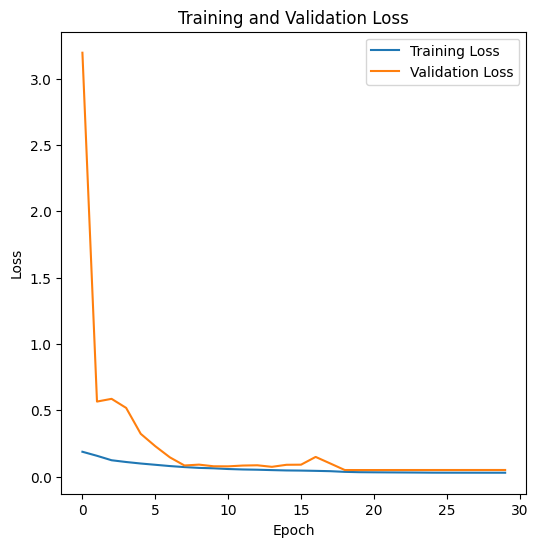

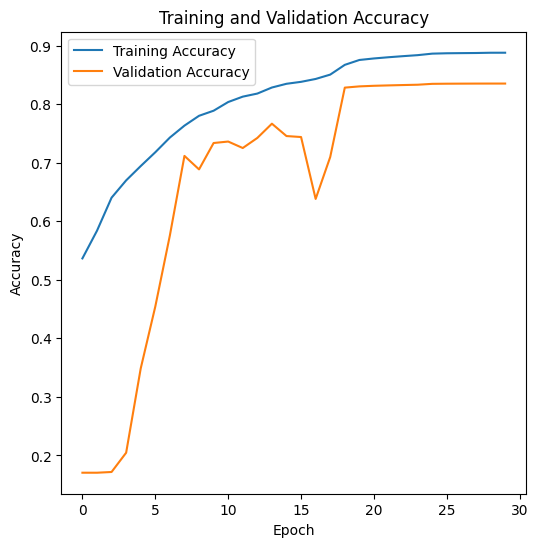

In [22]:
import pandas as pd
# Load the CSV log file
log_file = os.path.join(files_dir, "Log-Unet.csv")
log_data = pd.read_csv(log_file)
# Check available columns in the CSV
print(log_data.columns)

# Plot Training and Validation Loss
plt.figure(figsize=(6, 6))
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the Loss plot
loss_plot_file_path = os.path.join(files_dir, 'training_validation_loss.png')
plt.savefig(loss_plot_file_path)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 6))
plt.plot(log_data['categorical_accuracy'], label='Training Accuracy')
plt.plot(log_data['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the Accuracy plot
accuracy_plot_file_path = os.path.join(files_dir, 'training_validation_accuracy.png')
plt.savefig(accuracy_plot_file_path)  # Close the figure to free memory
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


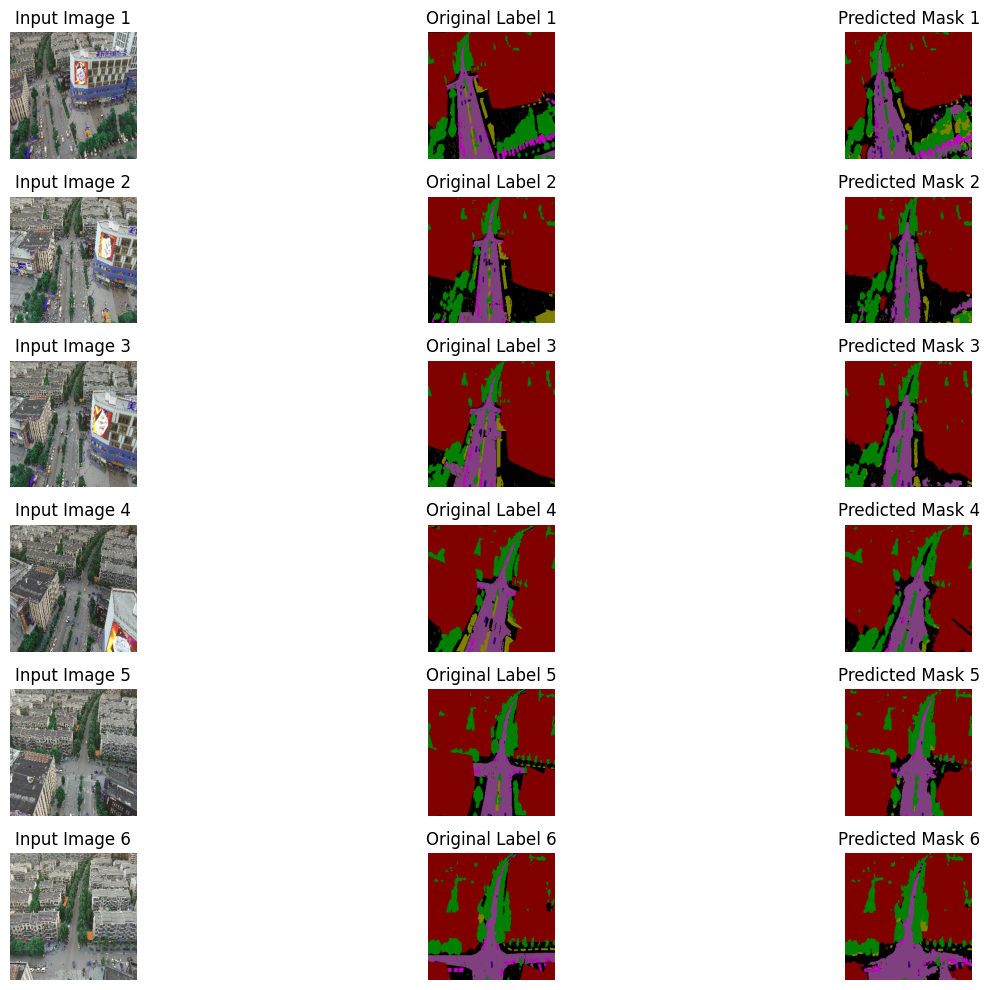

In [23]:
class_to_rgb = {v: k for k, v in color_map.items()}

class_colors = {k: tuple(v/255.0 for v in rgb) for k, rgb in class_to_rgb.items()}
colors = np.array([class_colors[i] for i in sorted(class_colors.keys())])
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(class_colors)+1) - 0.5, ncolors=len(class_colors))

def map_class_to_rgb(class_mask):
    rgb_mask = np.zeros((class_mask.shape[0], class_mask.shape[1], 3), dtype=np.uint8)
    for class_index, rgb in class_to_rgb.items():
        rgb_mask[class_mask == class_index] = rgb
    return rgb_mask


plt.figure(figsize=(15, 10))  

batch = next(iter(valid_dataset)) 
batch_x, batch_y = batch

num_images = batch_x.shape[0]

for i in range(num_images):

    image = batch_x[i].numpy()
    mask = batch_y[i].numpy()


    prediction = model.predict(np.expand_dims(image, axis=0))[0]  
    predicted_class_indices = np.argmax(prediction, axis=-1) 

    predicted_mask_rgb = map_class_to_rgb(predicted_class_indices)

    original_label_path = valid_y[i] 
    original_label = cv2.imread(original_label_path, cv2.IMREAD_COLOR)
    original_label = cv2.cvtColor(original_label, cv2.COLOR_BGR2RGB)
    original_label = cv2.resize(original_label, (width, height)) / 255.0

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(image)
    plt.title(f"Input Image {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(original_label)
    plt.title(f"Original Label {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(predicted_mask_rgb)
    plt.title(f"Predicted Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
time_taken = []
for x in tqdm(valid_x):
    
    seq_folder = x.split("/")[-3]
    image_name = x.split("/")[-1]
    
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    start_time = time.time()
    p = model.predict(x)[0] 
    total_time = time.time() - start_time
    time_taken.append(total_time)

    p_class_indices = np.argmax(p, axis=-1)  
    
    p_rgb = np.zeros((p_class_indices.shape[0], p_class_indices.shape[1], 3), dtype=np.uint8)
    
    for rgb, idx in color_map.items():
        p_rgb[p_class_indices == idx] = rgb 
    
    p_rgb = cv2.cvtColor(p_rgb, cv2.COLOR_RGB2BGR)

    save_path_with_name = os.path.join(save_path, f"{seq_folder}_{image_name}")
    cv2.imwrite(save_path_with_name, p_rgb)

  0%|          | 0/170 [00:00<?, ?it/s]


NameError: name 'time' is not defined

In [25]:
!zip -r UAVIDscse.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'UAVIDscse.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Prediction/ (stored 0%)
  adding: kaggle/working/Prediction/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/files/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/ (stored 0%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_accuracy.png (deflated 10%)
  adding: kaggle/working/files/modified_uavid_dataset/UnetModel.keras (deflated 9%)
  adding: kaggle/working/files/modified_uavid_dataset/training_validation_loss.png (deflated 12%)
  adding: kaggle/working/files/modified_uavid_dataset/Log-Unet.csv (deflated 58%)


/kaggle/working/UAVIDscse.zip